### Prime numbers recognition

We shall train a binary classifier on a subset of the MNIST set, in which we distinguish classes (digits 0 and 1 are to be excluded from the set):

* Prime numbers (2,3,5,7)
* Complex numbers (4,6,8,9)

### Model testing

We test our model with different parameters. Parameters such as number of iterations, threshold or number of samples differ and we can observe how it affects the model and its outcomes.

### Downloading packages and preparing notebook for training models

In [1]:
# required packages installation

!pip install -r ../requirements.txt

You should consider upgrading via the 'd:\p\anaconda\python.exe -m pip install --upgrade pip' command.


In [2]:
# importing model and required components
from core.models import LogisticRegression
from core.optimizers import *
from core.regularizers import *

# imports for data loading
from requests import get
import idx2numpy
import gzip
import shutil
import os

# import for data processing and analysis
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# warnings ignoring
import warnings; warnings.simplefilter('ignore')

### Data loading

#### This section is responsible for downloading the data on which our model will be trained in many scenarios - with variety of different:
- number of samples
- number of iterations
- thresholds

In [3]:
# data downloading and preprocessing function
        
def load_data():
    
    urls = []
    urls.append('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    urls.append('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    urls.append('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    urls.append('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
    
    print('Downloading data...')
    responses = [get(url, allow_redirects=True) for url in urls]
    
    names = ['train_images', 'train_labels', 'test_images', 'test_labels']
    
    for index, response in enumerate(responses):
        open(f'./datasets/prime_numbers/{names[index]}-gz', 'wb').write(response.content)
        
    print('Unpacking files...')
    for name in names:
        with gzip.open(f'./datasets/prime_numbers/{name}-gz', 'rb') as f_in:
            with open(f'./datasets/prime_numbers/{name}', 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
 
    for name in names:
        os.remove(f'./datasets/prime_numbers/{name}-gz')

    f_read = open('./datasets/prime_numbers/train_images','rb')
    X_train = idx2numpy.convert_from_file(f_read)

    f_read = open('./datasets/prime_numbers/train_labels', 'rb')
    y_train = idx2numpy.convert_from_file(f_read)

    f_read = open('./datasets/prime_numbers/test_images', 'rb')
    X_test = idx2numpy.convert_from_file(f_read)
    
    f_read = open('./datasets/prime_numbers/test_labels', 'rb')
    y_test = idx2numpy.convert_from_file(f_read)


    X_train = X_train.reshape(len(X_train), 784)
    X_test = X_test.reshape(len(X_test), 784)


    tmp_X = []
    tmp_y = []

    for index,label in enumerate(y_train):
        if label in [2,3,5,7]:
            tmp_X.append(X_train[index])
            tmp_y.append(1)
        elif label in [4,6,8,9]:
            tmp_X.append(X_train[index])
            tmp_y.append(0)

    tmp_X_test = []
    tmp_y_test = []

    for index,label in enumerate(y_test):
        if label in [2,3,5,7]:
            tmp_X_test.append(X_test[index])
            tmp_y_test.append(1)
        elif label in [4,6,8,9]:
            tmp_X_test.append(X_test[index])
            tmp_y_test.append(0)


    X_train = np.array(tmp_X)
    X_test = np.array(tmp_X_test)
    y_train = np.array(tmp_y)
    y_test = np.array(tmp_y_test)
    
    print('Data loading finished!')
    
    return X_train, X_test, y_train, y_test

In [4]:
# data loading

X_train_raw, X_test, y_train_raw, y_test = load_data()

Unpacking files...
Data loading finished!


## Data visualization

#### Number of training and testing samples + Single Record Visualization

Num of our training samples: 	 47335
Num of our testing samples: 	 7885


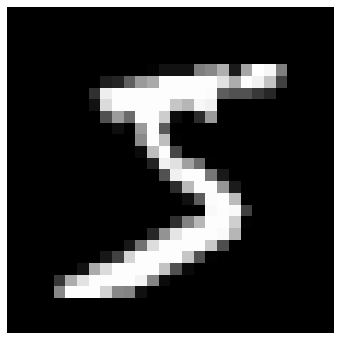

In [5]:
print("Num of our training samples: \t", X_train_raw.shape[0])
print("Num of our testing samples: \t", X_test.shape[0])

number = np.reshape(X_train_raw[0], (28,28))

plt.figure(figsize=(6, 6))
plt.imshow(number, cmap='gray')
plt.axis('off')
plt.show()

#### Training sample

##### Examples with labels attached

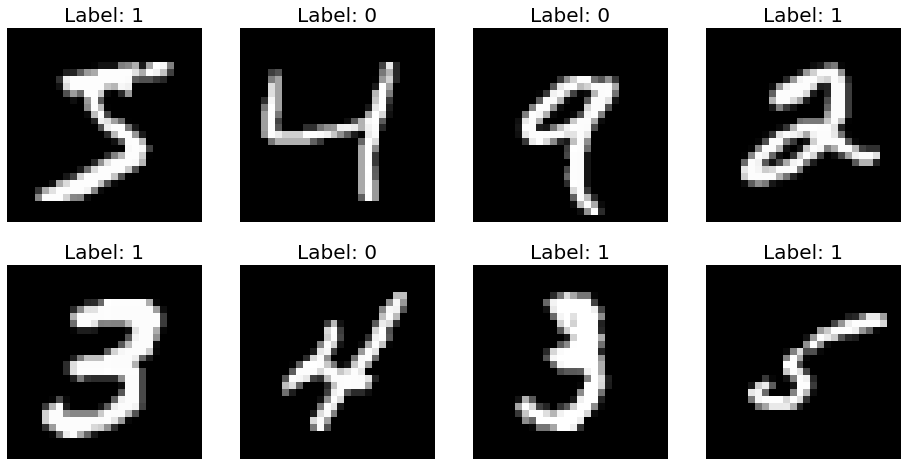

In [6]:
plt.figure(figsize=(16,8))

for i, (X, label) in enumerate(zip(X_train_raw[0:8], y_train_raw[0:8])):
    plt.subplot(2, 4, i + 1)
    plt.title(f'Label: {label}', fontsize = 20)
    plt.axis('off')
    plt.imshow(np.reshape(X, (28,28)), cmap='gray')
plt.show()

#### Taking num of samples we want to train our model on 

In [7]:
num_of_samples = 10000

X_train = X_train_raw[:num_of_samples]
y_train = y_train_raw[:num_of_samples]

### Helper function for comparison displaying

In [8]:
def display_comparison(report , labels, metric = 'precision'):

    precision_0 = [round(report['0'][metric],2) for report in report]
    precision_1 = [round(report['1'][metric],2) for report in report]

    x = np.arange(len(report))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 5))

    rects1 = ax.bar(x - width/2 , precision_0, width, label=f'{metric} 0')
    rects2 = ax.bar(x + width/2, precision_1, width, label=f'{metric} 1')

    ax.set_ylabel(metric)
    ax.set_title('Comparison of the prescription results for different optimizers')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

## Default model efficienty

#### Cross validation score determination on model with default parameters

In [9]:
model = LogisticRegression()
result = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', error_score='raise')

In [10]:
print('Cross validation result')
print(result)
print('Cross validation mean')
print(np.mean(result))

Cross validation result
[0.9125 0.881  0.912  0.8985 0.82  ]
Cross validation mean
0.8847999999999999


## Optimizers testing

In [11]:
# appending all optimizers to check their efficiency

optimizers = [
    GradientDescentOptimizer(),
    MomentumGradientDescentOptimizer(),
    AdaGradOptimizer(),
    RMSPropOptimizer()
]

In [12]:
# regularizer=RidgeRegularizer(), num_iterations=300, threshold=0.5, fit_intercept=True, verbose=False

optimizers_report = []

for optimizer in optimizers:
    model = LogisticRegression(optimizer = optimizer)
    model.fit(X_train_raw, y_train_raw)
    y_pred = model.predict(X_test)
    print("="*80)
    print(str(optimizer).center(80, ' '))
    print("="*80)
    print(classification_report(y_test, y_pred))
    optimizers_report.append(classification_report(y_test, y_pred, output_dict = True))

                 GradientDescentOptimizer(learning_rate: 0.03)                  
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3923
           1       0.91      0.91      0.91      3962

    accuracy                           0.91      7885
   macro avg       0.91      0.91      0.91      7885
weighted avg       0.91      0.91      0.91      7885

   MomentumGradientDescentOptimizer(learning_rate: 0.03, momentum_rate: 0.9)    
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      3923
           1       0.86      0.94      0.90      3962

    accuracy                           0.90      7885
   macro avg       0.90      0.90      0.90      7885
weighted avg       0.90      0.90      0.90      7885

             AdaGradOptimizer(learning_rate: 0.03, epsilon: 1e-07)              
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     

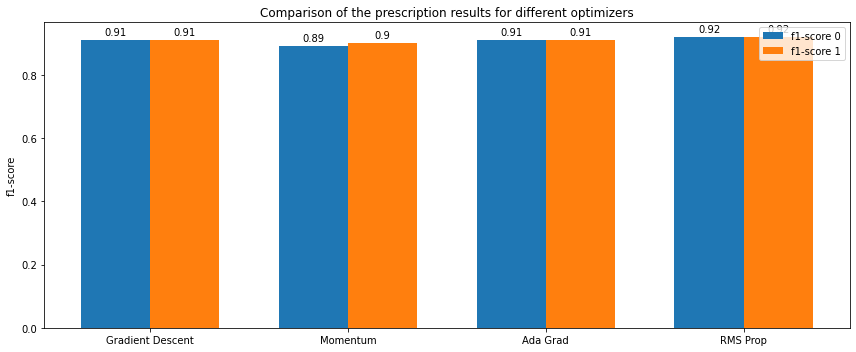

In [13]:
labels = ['Gradient Descent', 'Momentum', 'Ada Grad', 'RMS Prop']
display_comparison(optimizers_report, labels, 'f1-score')

## Regularizers testing

In [14]:
# appending all regularizers to check their efficiency

regularizers = [
    LassoRegularizer(),
    RidgeRegularizer(),
    ElasticNetRegularizer()
]

#### Below we test all three regularizers

Default values provided to *LinearRegression* model:
- *num_iterations* = 300 <- number of iterations of the optimizer algorithm
- *threshold* = 0.5 <- decision threshold
- *fit_intercept* = True <- whether to calculate the intercept for this model
- *verbose* = False <- output-related parameter

In [15]:
# optimizer = RMSPropOptimizer, num_iterations=300, threshold=0.5, fit_intercept=True, verbose=False

regularizers_report = []

for regularizer in regularizers:
    model = LogisticRegression(regularizer = regularizer)
    model.fit(X_train_raw, y_train_raw)
    y_pred = model.predict(X_test)
    print("="*80)
    print(str(regularizer).center(80, ' '))
    print("="*80)
    print(classification_report(y_test, y_pred))
    regularizers_report.append(classification_report(y_test, y_pred, output_dict = True))

                          LassoRegularizer(alpha: 0.1)                          
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3923
           1       0.90      0.94      0.92      3962

    accuracy                           0.92      7885
   macro avg       0.92      0.91      0.91      7885
weighted avg       0.92      0.92      0.91      7885

                          RidgeRegularizer(alpha: 0.1)                          
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3923
           1       0.97      0.78      0.87      3962

    accuracy                           0.88      7885
   macro avg       0.89      0.88      0.88      7885
weighted avg       0.89      0.88      0.88      7885

            ElasticNetRegularizer(alpha: 0.1, beta: 0.1, gamma: 0.8)            
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     

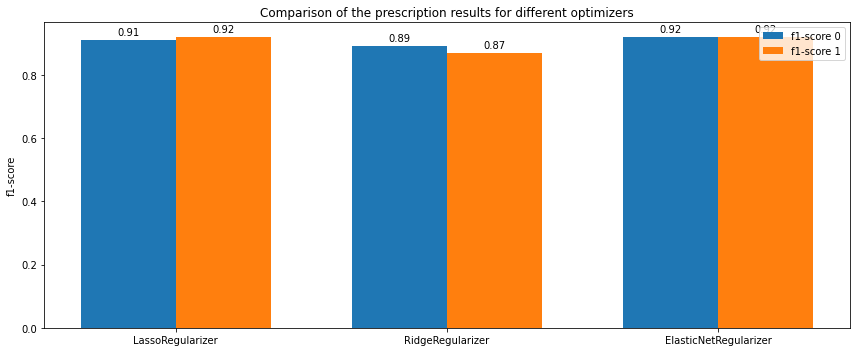

In [16]:
labels = ['LassoRegularizer', 'RidgeRegularizer', 'ElasticNetRegularizer']
display_comparison(regularizers_report, labels, metric='f1-score')

### Different amounts of samples during model training

#### In this section we check how different amount of samples affects the model and scores, precision etc.

In [17]:
print('Number of all samples: ', len(X_train_raw))

Number of all samples:  47335


In [18]:
num_of_samples = [5, 100, 500, 1000, 2000, 5000, 10000, 20000]

##### Creating models with different sample number

In [19]:
num_samples_report = []

for num in num_of_samples:
    model = LogisticRegression()
    model.fit(X_train_raw[:num], y_train_raw[:num])
    y_pred = model.predict(X_test)
    print(('" '+ str(num) +' samples "').center(53, '='))
    print(classification_report(y_test, y_pred))
    num_samples_report.append(classification_report(y_test, y_pred, output_dict = True))

====================" 5 samples "====================
              precision    recall  f1-score   support

           0       0.70      0.58      0.63      3923
           1       0.64      0.75      0.69      3962

    accuracy                           0.67      7885
   macro avg       0.67      0.67      0.66      7885
weighted avg       0.67      0.67      0.66      7885

===================" 100 samples "===================
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      3923
           1       0.87      0.72      0.79      3962

    accuracy                           0.81      7885
   macro avg       0.82      0.81      0.81      7885
weighted avg       0.82      0.81      0.81      7885

===================" 500 samples "===================
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3923
           1       0.86      0.88      0.87      3962

    accuracy        

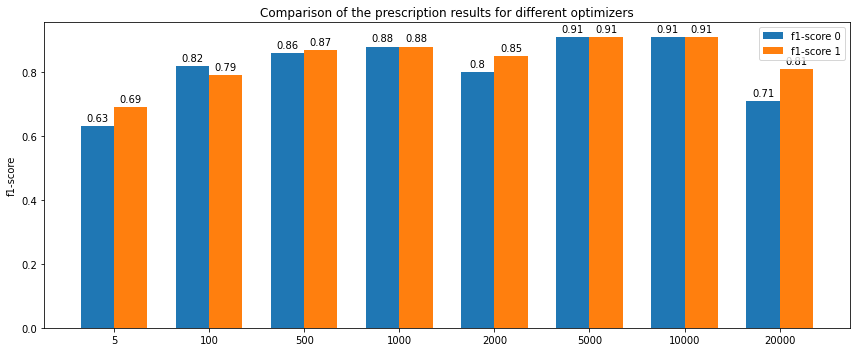

In [20]:
display_comparison(num_samples_report, num_of_samples, metric = 'f1-score')

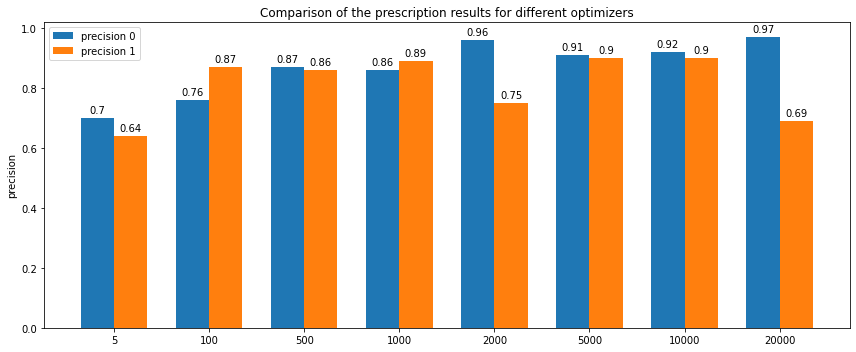

In [30]:
display_comparison(num_samples_report, num_of_samples, metric = 'precision')

### Different amounts of iterations during model training

#### In this section we check how different amounts of iterations affect the model and other parameters.

In [37]:
num_of_iterations = [100, 300, 500, 1000, 3000, 7000]

##### Creating models with different iteration number

In [38]:
num_iterations_report = []

for num in num_of_iterations:
    model = LogisticRegression(num_iterations=num)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(('" '+ str(num) +' iterations "').center(53, '='))
    print(classification_report(y_test, y_pred))
    num_iterations_report.append(classification_report(y_test, y_pred, output_dict = True))

==================" 100 iterations "=================
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      3923
           1       0.82      0.96      0.89      3962

    accuracy                           0.87      7885
   macro avg       0.89      0.87      0.87      7885
weighted avg       0.89      0.87      0.87      7885

==================" 300 iterations "=================
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      3923
           1       0.84      0.96      0.89      3962

    accuracy                           0.89      7885
   macro avg       0.89      0.89      0.89      7885
weighted avg       0.89      0.89      0.89      7885

==================" 500 iterations "=================
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3923
           1       0.90      0.92      0.91      3962

    accuracy        

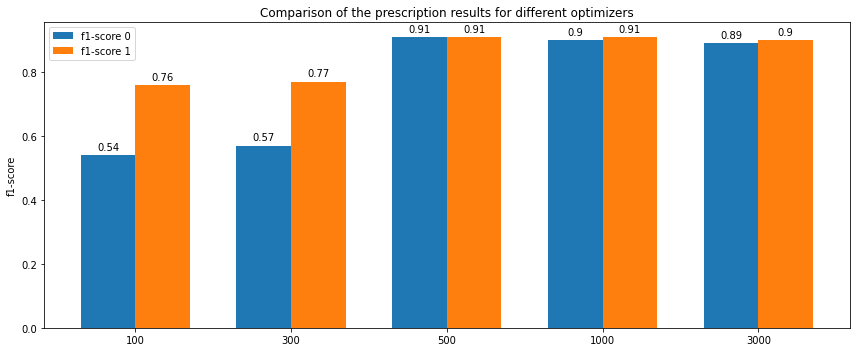

In [36]:
display_comparison(num_iterations_report, num_of_iterations, metric='f1-score')

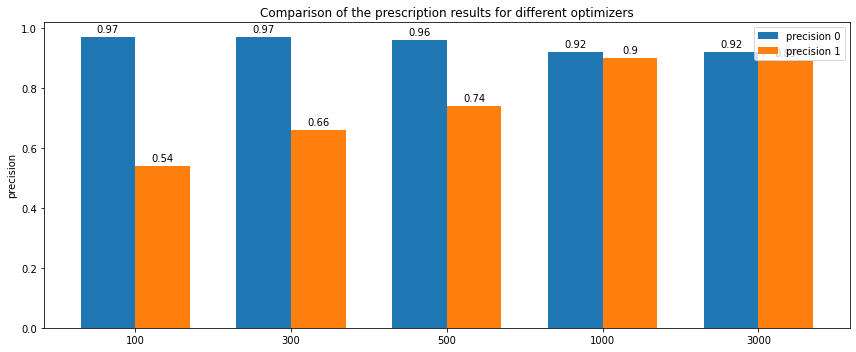

In [34]:
display_comparison(num_iterations_report, num_of_iterations, metric='precision')

## Summary

Our goal was to find whether a number is prime or not. We have training samples of length 784 so our model is going to have 784 parameters. That's a lot of calculations. We wanted to test our model with different parameters and check their efficiency. In our comparison we will be considering f1-score.
In first two parts where we were testing implemented optimizers and regularizers we can observe only slight differences, and our results oscillate around the value 0.9, so we can consider them comparable and satisfying.
In the next parts we were testing number of samples on which we were trying our model and number of iterations.
In a number of samples testing we can observe that the best results are obatined by training on 500-5000 samples. When we take less samples the model has no oportunity to get to know how to discriminate the numbers and when number of samples is greater than 5000 the model don't get better results, so there is no need to take more than 5000 samples for training.
Analyzing number of iterations given for training we can see that our model's f1-score gets better with greater number of iterations - that isn't surprising. However we have to remember about overfitting, and we can see that our results don't get better above 1000 number of iterations so there is no need to take more for training.